# Predicting Diabetes Onset
### By: Bethany Thompson
### Date: December 2020
## Goals
- Create a machine learning algorithm to predict if a patient has diabetes or not  

## Conclusions
#### Final Model Selected:
#### Model Metrics:
## Next Steps
## How to Reproduce:

In [9]:
# initial imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Acquire
Dataset from UCI Machine Learning via Kaggle [here](https://www.kaggle.com/uciml/pima-indians-diabetes-database) saved in .csv file  
#### Steps:
- read csv file into df
- summarize data
- create data dictionary

In [3]:
df = pd.read_csv('diabetes.csv')

In [17]:
df.shape

(768, 9)

In [6]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [4]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


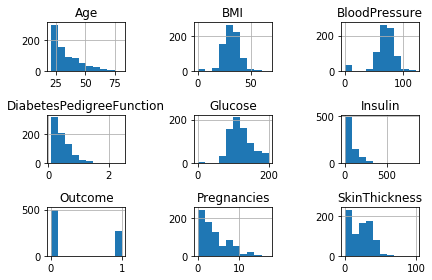

In [15]:
df.hist()
plt.tight_layout()

### Takeaways
- 768 observations
    - 8 columns and 1 predictive column as diabetic or not
- no null values
- all numeric values, integers or floats

# Prepare
For Exploration:
- create new features

For Modeling:
- scale the data
- determine if outliers/anomalies to remove
- split into train, valideate, test

# Explore

# Modeling

# Conclusions